# ABOVEGROUND BIOMASS ESTIMATION PROJECT

# Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import rasterio


# Load Training and Testing Sets

In [2]:
# Load the exported training and testing sets
training_set = pd.read_csv('E:/CLIENTS/AGB/New/training_set.csv')
testing_set = pd.read_csv('E:/CLIENTS/AGB/New/testing_set.csv')

# Display the first few rows of the datasets
training_set.head(), testing_set.head()


(           system:index      ARVI     B11    B12     B2     B3     B4     B5  \
 0  202005_078E_024N_963  0.867114  1139.0  573.0  117.0  264.0  222.0  558.0   
 1   202009_078E_024N_50  0.837050   959.0  443.0  220.5  444.5  321.5  652.5   
 2  202005_078E_024N_306  0.889146  1552.0  665.0  182.0  440.0  277.0  822.0   
 3  202010_078E_024N_103  0.776372  1466.5  865.0  261.0  538.0  468.5  888.0   
 4  202009_078E_024N_543  0.854229  1407.0  638.0  203.0  483.0  378.0  873.0   
 
        B6      B7  ...       LAI      MTCI      NDVI       REIP        RVI  \
 0  1456.0  1699.0  ...  6.467464  2.840855  0.743473  716.66670   6.796460   
 1  1751.5  2158.5  ...  6.482764  4.001009  0.741419  719.19543   6.745686   
 2  2420.0  2800.0  ...  7.641999  3.484266  0.836385  717.60913  11.223826   
 3  1845.0  2079.5  ...  5.317954  2.739499  0.639073  715.79750   4.542175   
 4  2306.0  2776.0  ...  6.823006  3.493548  0.746635  719.04420   6.893750   
 
           VH         VV        agbd

# Prepare Feature Columns and Target Column

In [3]:
# Define the feature columns and target column
features = ['VV', 'VH', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 
            'NDVI', 'GRVI', 'LAI', 'DVI', 'IRECI', 'RVI', 'MTCI', 'ARVI', 'REIP']
target = 'agbd'

# Prepare the feature matrix and target vector for training and testing sets
X_train = training_set[features]
y_train = training_set[target]
X_test = testing_set[features]
y_test = testing_set[target]


# Train the Regression Model

In [4]:
# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

# Evaluate the Model

Mean Squared Error: 2705.8923034314766
R^2 Score: 0.8683529765344395


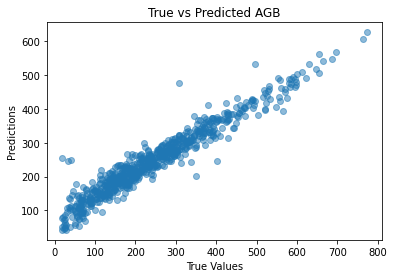

In [5]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Plot the true vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted AGB')
plt.show()


# Load Processed Image Composites

In [6]:
# Load the processed image composites
s1_composite = rasterio.open('E:/CLIENTS/AGB/New/s1_composite.tif')
s2_composite = rasterio.open('E:/CLIENTS/AGB/New/s2_composite.tif')
alos_composite = rasterio.open('E:/CLIENTS/AGB/New/alos_composite.tif')

# Read the image data
s1_data = s1_composite.read()
s2_data = s2_composite.read()
alos_data = alos_composite.read()


# Combine Image Data and Reshape for Prediction

In [7]:
# Combine all image data into a single array
combined_data = np.concatenate((s1_data, s2_data, alos_data), axis=0)

# Reshape the data for prediction
n_samples = combined_data.shape[1] * combined_data.shape[2]
combined_data_reshaped = combined_data.reshape((combined_data.shape[0], n_samples)).T


#  Make AGB Predictions and Save as GeoTIFF

In [12]:
# Handle NaN values by filling them with the mean of each feature
combined_data_reshaped_df = pd.DataFrame(combined_data_reshaped, columns=[
    'VV', 'VH', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 
    'NDVI', 'GRVI', 'LAI', 'DVI', 'IRECI', 'RVI', 'MTCI', 'ARVI', 'REIP'
])

# No need to redefine features_used_during_training as it's already correct

# Fill NaN values
combined_data_reshaped_df.fillna(combined_data_reshaped_df.mean(), inplace=True)

# Convert back to numpy array
combined_data_reshaped = combined_data_reshaped_df.to_numpy()

# Make predictions on the image data
agb_predictions = model.predict(combined_data_reshaped)
agb_predictions_image = agb_predictions.reshape((combined_data.shape[1], combined_data.shape[2]))

# Save the AGB predictions as a new GeoTIFF
agb_predictions_image_tiff = 'E:/CLIENTS/AGB/New/pred/agb_predictions_image.tif'
agb_predictions_image_raster = rasterio.open(
    agb_predictions_image_tiff, 'w',
    driver='GTiff', height=agb_predictions_image.shape[0],
    width=agb_predictions_image.shape[1], count=1, dtype=agb_predictions_image.dtype,
    crs=s2_composite.crs, transform=s2_composite.transform
)
agb_predictions_image_raster.write(agb_predictions_image, 1)
agb_predictions_image_raster.close()

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


# masked predicted image

In [15]:
# Create a mask for valid data
valid_mask = (s2_composite.read(1) != s2_composite.nodata)

# Reshape the data for prediction, applying the mask
n_samples = valid_mask.sum()
combined_data_reshaped = combined_data.reshape((combined_data.shape[0], -1))[:, valid_mask.ravel()]
combined_data_reshaped = combined_data_reshaped.T

# Define the 20 features used during training
feature_names = ['VV', 'VH', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 
                 'NDVI', 'GRVI', 'LAI', 'DVI', 'IRECI', 'RVI', 'MTCI', 'ARVI', 'REIP']

# Create DataFrame with only the 20 features used during training
combined_data_reshaped_df = pd.DataFrame(combined_data_reshaped[:, :20], columns=feature_names)

# Fill NaN values
combined_data_reshaped_df.fillna(combined_data_reshaped_df.mean(), inplace=True)

# Convert back to numpy array
combined_data_reshaped = combined_data_reshaped_df.to_numpy()

# Make predictions on the masked data
agb_predictions = model.predict(combined_data_reshaped)

# Create a full-sized output array filled with nodata value
nodata_value = -9999  # Choose an appropriate nodata value
agb_predictions_full = np.full((combined_data.shape[1], combined_data.shape[2]), nodata_value, dtype=np.float32)

# Fill in the valid predictions
agb_predictions_full[valid_mask] = agb_predictions

# Save the AGB predictions as a new GeoTIFF
agb_predictions_image_tiff = 'E:/CLIENTS/AGB/New/pred/masked_agb_predictions_image.tif'
agb_predictions_image_raster = rasterio.open(
    agb_predictions_image_tiff, 'w',
    driver='GTiff', height=agb_predictions_full.shape[0],
    width=agb_predictions_full.shape[1], count=1, dtype=agb_predictions_full.dtype,
    crs=s2_composite.crs, transform=s2_composite.transform, nodata=nodata_value
)
agb_predictions_image_raster.write(agb_predictions_full, 1)
agb_predictions_image_raster.close()

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


# Additional metrics

In [16]:
from sklearn.metrics import mean_absolute_error, explained_variance_score, max_error

# Calculate additional metrics
mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
me = max_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Explained Variance Score: {evs}')
print(f'Maximum Error: {me}')

Mean Absolute Error: 39.41962454092153
Explained Variance Score: 0.8686612387867898
Maximum Error: 235.93764728762025


# Residual plot

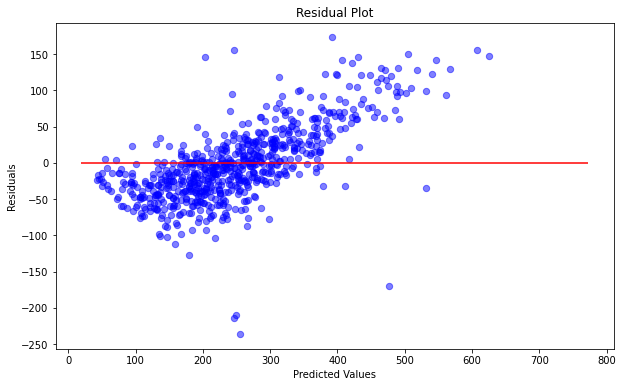

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test - y_pred, c='b', s=40, alpha=0.5)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), color='r')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
# plt.savefig('E:/CLIENTS/AGB/New/pred/residual_plot.png')
plt.close()

# Prediction error distribution

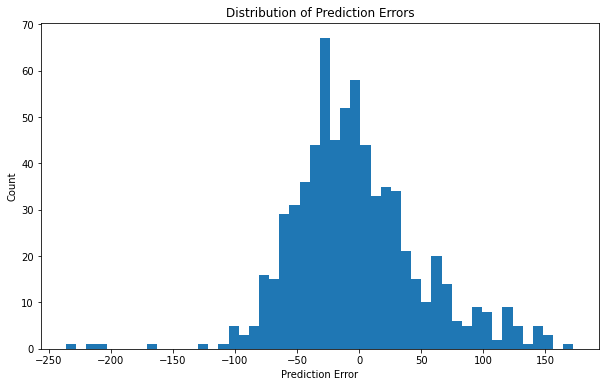

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(y_test - y_pred, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.show()
plt.savefig('E:/CLIENTS/AGB/New/pred/error_distribution.png')
plt.close()

# Feature importance plot

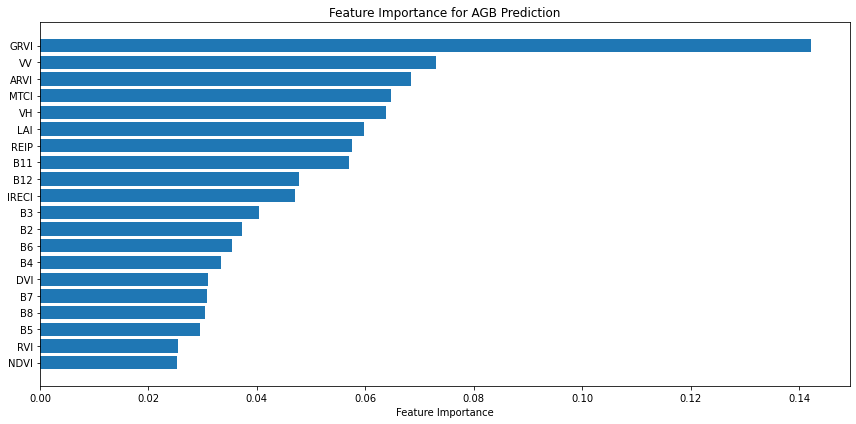

In [20]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for AGB Prediction')
plt.tight_layout()
plt.show()
plt.savefig('E:/CLIENTS/AGB/New/pred/feature_importance.png')
plt.close()

# Predicted vs Actual

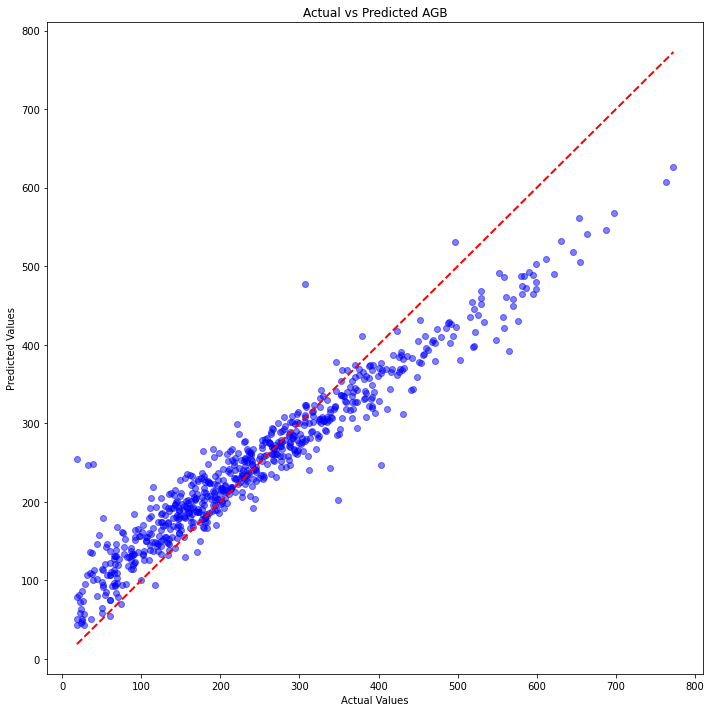

In [21]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, c='b', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted AGB')
plt.tight_layout()
plt.show()
plt.savefig('E:/CLIENTS/AGB/New/pred/actual_vs_predicted.png')
plt.close()

# Density plots

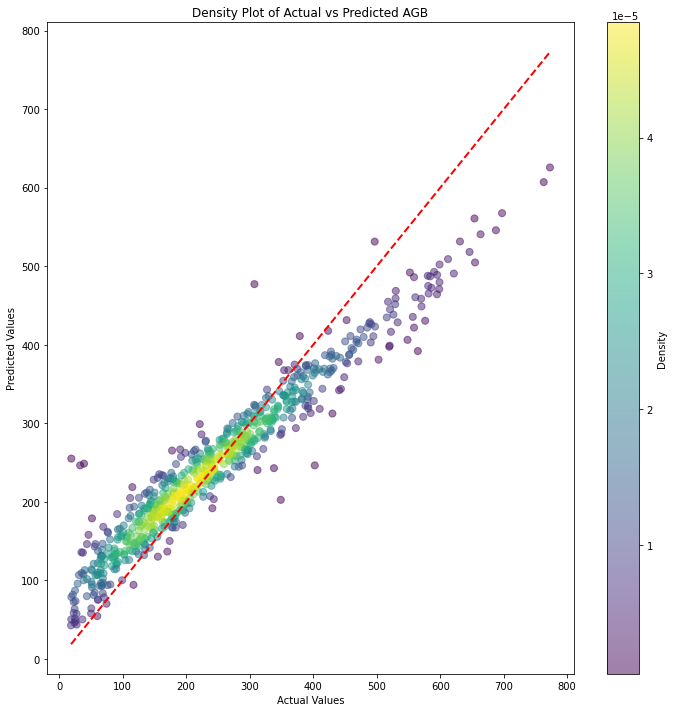

In [22]:
from scipy import stats

plt.figure(figsize=(10, 10))
xy = np.vstack([y_test, y_pred])
z = stats.gaussian_kde(xy)(xy)

plt.scatter(y_test, y_pred, c=z, s=50, alpha=0.5)
plt.colorbar(label='Density')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Density Plot of Actual vs Predicted AGB')
plt.tight_layout()
plt.show()
plt.savefig('E:/CLIENTS/AGB/New/pred/density_actual_vs_predicted.png')
plt.close()

# QQ Plots

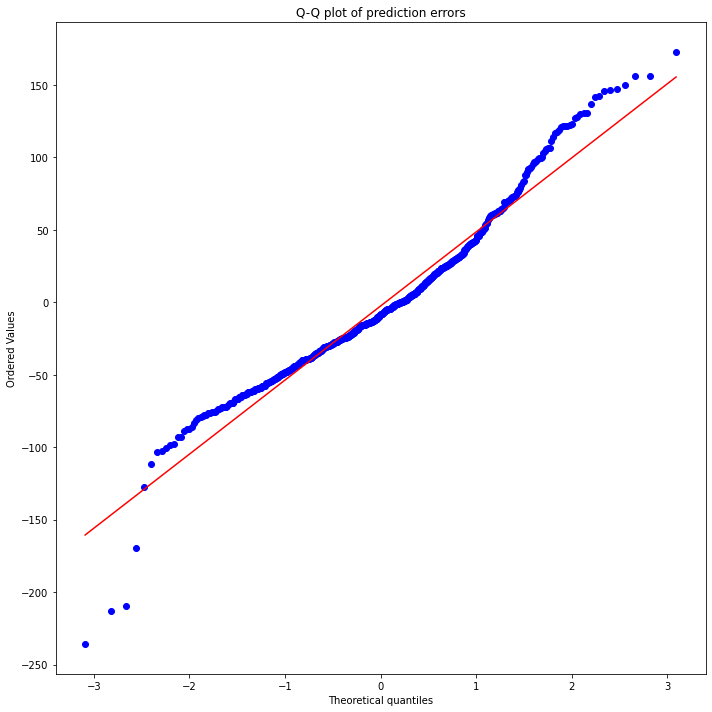

In [23]:
from scipy import stats

plt.figure(figsize=(10, 10))
stats.probplot(y_test - y_pred, dist="norm", plot=plt)
plt.title("Q-Q plot of prediction errors")
plt.tight_layout()
plt.show()
plt.savefig('E:/CLIENTS/AGB/New/pred/qq_plot.png')
plt.close()